In [1]:
%matplotlib inline
import pickle
import pandas as pd
import seaborn as sns

## Loading 2017 train data

In [2]:
with open('../data/processed/data.pkl', 'rb') as pf:
    objs = pickle.load(pf)

grammar_dic = objs[0]
df_17_train = objs[1]

df_17_train_vecsim = pd.read_csv('../data/processed/df17_train_fasttext.csv')
df_17_train_grmerr = pd.read_csv('../data/processed/df17_train_grmerror.csv')

Form a DF for modeling
- df_17_train, only using Id, language, and meaning cols
- using Id to merge all features.

In [3]:
df_17_train_ml = df_17_train[['Id', 'language', 'meaning']]
df_17_train_ml = pd.merge(df_17_train_ml, df_17_train_vecsim, on='Id')
df_17_train_ml = pd.merge(df_17_train_ml, df_17_train_grmerr, on='Id')
print(df_17_train_ml.head(1))

with pd.option_context('mode.use_inf_as_null', True):
    df_17_train_ml.dropna(inplace=True)

print(df_17_train_ml.describe())

     Id language  meaning  cos_mean  cos_max  wmd_mean  wmd_min  \
0  5835  correct  correct   0.86156      1.0  1.717595      0.0   

   ofto_error_count  Spell  Article_a_an_error_count  sva_error_count  \
0                 0      0                         0                0   

   RuleRepeatedLinkWords_error_count  Verbform_error_count  noun_error_count  \
0                                  0                     0                 0   

   Article_error_count  AdjAdv_error_count  Wordform_error_count  \
0                    0                   0                     0   

   VerbCollocation_error_count  
0                            0  


                 Id     cos_mean      cos_max     wmd_mean      wmd_min  \
count   5139.000000  5139.000000  5139.000000  5139.000000  5139.000000   
mean    8804.105079     0.845628     0.975997     1.470314     0.229293   
std     1696.450313     0.095431     0.066667     0.564620     0.504884   
min     5835.000000     0.215128     0.261320     0.000000     0.000000   
25%     7348.500000     0.786995     0.992128     1.143183     0.000000   
50%     8843.000000     0.869039     1.000000     1.414952     0.000000   
75%    10270.500000     0.914371     1.000000     1.727163     0.254001   
max    11676.000000     1.000000     1.000000     5.282630     4.822643   

       ofto_error_count   Spell  Article_a_an_error_count  sva_error_count  \
count            5139.0  5139.0               5139.000000      5139.000000   
mean                0.0     0.0                  0.001362         0.013816   
std                 0.0     0.0                  0.036886         0.116738   
min         

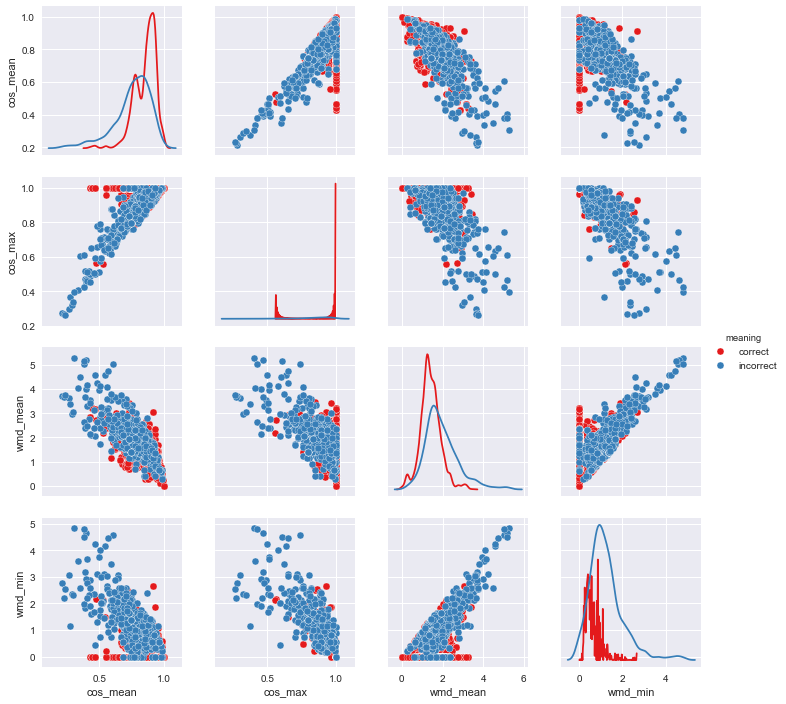

In [4]:
sns.pairplot(df_17_train_ml[['cos_mean', 'cos_max', 'wmd_mean', 'wmd_min', 'meaning']],
             hue='meaning', dropna=True, diag_kind='kde',
             palette="Set1", size=2.5)

In [5]:
from sklearn.model_selection import train_test_split

df_17_train_ml = df_17_train_ml.drop(['Id'], axis=1)
X = df_17_train_ml.loc[:,'cos_mean' : 'VerbCollocation_error_count'].values
y = df_17_train_ml.loc[:,'language': 'meaning'].values
print(X.shape)
print(y.shape)

# y = le.transform(y)

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.2, random_state=0)

print(y_train)

(5139, 15)
(5139, 2)
[['correct' 'correct']
 ['correct' 'correct']
 ['correct' 'correct']
 ...
 ['correct' 'correct']
 ['correct' 'correct']
 ['correct' 'correct']]


In [7]:
def get_langauge_X(X):
    return X[:, 4:-1]

def get_langauge_y(y):
    return y[:,0]

def get_meaning_X(X):
    return X[:,0:3]

def get_meaning_y(y):
    return y[:,1]

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from colorama import Fore

def use_lr_model(X_train, y_train, X_dev, y_dev, X_test, y_test):
    param_grid = [{'penalty': ['l2'],
                   'C': [1.0, 0.5, 0.25, 0.1],
                   'dual' : [False],
                   'max_iter': [400, 1000],
                   'solver': ['lbfgs']}]

    clf = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5,
                       scoring='accuracy')
    clf.fit(X_train, y_train)

    print('Best parameters set found: ')
    print(Fore.GREEN + str(clf.best_params_))
    
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    
    # prob output
    y_dev_prob = clf.predict_proba(X_dev)
    y_test_prob = clf.predict_proba(X_test)
    
    return (y_dev_prob, y_test_prob)
    
    

In [24]:
# for language
lang_dev_prob, lang_test_prob = use_lr_model(get_langauge_X(X_train), get_langauge_y(y_train),
                                             get_langauge_X(X_dev), get_langauge_y(y_dev),
                                             get_langauge_X(X_test), get_langauge_y(y_test))


Best parameters set found: 
{'C': 1.0, 'dual': False, 'max_iter': 400, 'penalty': 'l2', 'solver': 'lbfgs'}
             precision    recall  f1-score   support

    correct       0.92      1.00      0.96       921
  incorrect       0.94      0.30      0.45       107

avg / total       0.93      0.93      0.91      1028



In [25]:

# for meaning
meaning_dev_prob, meaning_test_prob = use_lr_model(get_meaning_X(X_train), get_meaning_y(y_train),
                                                   get_meaning_X(X_dev), get_meaning_y(y_dev),
                                                   get_meaning_X(X_test), get_meaning_y(y_test))


Best parameters set found: 
{'C': 1.0, 'dual': False, 'max_iter': 400, 'penalty': 'l2', 'solver': 'lbfgs'}
             precision    recall  f1-score   support

    correct       0.92      1.00      0.96       921
  incorrect       0.94      0.30      0.45       107

avg / total       0.93      0.93      0.91      1028



In [10]:
# from CALL

def init_scores():
    return {'CorrectAccept': 0, 'GrossFalseAccept': 0, 'PlainFalseAccept': 0, 'CorrectReject': 0, 'FalseReject': 0}

# Compare decision with gold standard judgements for language and meaning
def score_decision(decision, language_correct_gs, meaning_correct_gs, scores):
    if ( decision == 'accept' and language_correct_gs == 'correct' ):
        result = 'CorrectAccept'
    elif ( decision == 'accept' and meaning_correct_gs == 'incorrect' ):
        result = 'GrossFalseAccept'
    elif ( decision == 'accept' ):
        result = 'PlainFalseAccept'
    elif ( decision == 'reject' and language_correct_gs == 'incorrect' ):
        result = 'CorrectReject'
    else:
        result = 'FalseReject'
    scores[result] = scores[result] + 1
    return result

def get_D(scores):
    CA = scores['CorrectAccept']
    GFA = scores['GrossFalseAccept']
    PFA = scores['PlainFalseAccept']
    CR = scores['CorrectReject']
    FR = scores['FalseReject']
    k = 3

    FA = PFA + k * GFA
    Correct = CA + FR
    Incorrect = CR + GFA + PFA
    
    if ( CR + FA ) > 0 :
        IncorrectRejectionRate = CR / ( CR + FA )
    else:
        IncorrectRejectionRate = 'undefined'

    if ( FR + CA ) > 0 :
        CorrectRejectionRate = FR / ( FR + CA )
    else:
        CorrectRejectionRate = 'undefined'

    if ( CorrectRejectionRate != 'undefined' and IncorrectRejectionRate != 'undefined' ) :
        D = IncorrectRejectionRate / CorrectRejectionRate 
    else:
        D = 'undefined'
    return D


def print_scores(scores):
    CA = scores['CorrectAccept']
    GFA = scores['GrossFalseAccept']
    PFA = scores['PlainFalseAccept']
    CR = scores['CorrectReject']
    FR = scores['FalseReject']
    k = 3

    FA = PFA + k * GFA
    Correct = CA + FR
    Incorrect = CR + GFA + PFA
    
    if ( CR + FA ) > 0 :
        IncorrectRejectionRate = CR / ( CR + FA )
    else:
        IncorrectRejectionRate = 'undefined'

    if ( FR + CA ) > 0 :
        CorrectRejectionRate = FR / ( FR + CA )
    else:
        CorrectRejectionRate = 'undefined'

    if ( CorrectRejectionRate != 'undefined' and IncorrectRejectionRate != 'undefined' ) :
        D = IncorrectRejectionRate / CorrectRejectionRate 
    else:
        D = 'undefined'

    print('\nINCORRECT UTTERANCES (' + str(Incorrect) + ')' )
    print('CorrectReject    ' + str(CR) )
    print('GrossFalseAccept ' + str(GFA) + '*' + str(k) + ' = ' + str(GFA * k) )
    print('PlainFalseAccept ' + str(PFA) )
    print('RejectionRate    ' + two_digits(IncorrectRejectionRate) )

    print('\nCORRECT UTTERANCES (' + str(Correct) + ')')
    print('CorrectAccept    ' + str(CA) )
    print('FalseReject      ' + str(FR) )
    print('RejectionRate    ' + two_digits(CorrectRejectionRate) )

    print('\nD                ' + two_digits(D) )

def two_digits(x):
    if x == 'undefined':
        return 'undefined'
    else:
        return ( "%.2f" % x )

In [11]:
def get_D_based_thresholds(LANG_T, MEAN_T, lang_prob, meaning_prob, y, print=False):
    scores = init_scores()
    for i, (p_lang, p_meaning) in enumerate(zip(lang_prob, meaning_prob)):
        if p_lang[0] >= LANG_T and p_meaning[0] >= MEAN_T:
            decision = 'accept'
        else:
            decision = 'reject'
        score_decision(decision, get_langauge_y(y)[i], get_meaning_y(y)[i], scores)
    if print:
        print_scores(scores)
    return get_D(scores)

        
import pylab as pl
lang_thres = pl.frange(0.25, 0.50, 0.050)
mean_thres = pl.frange(0.35, 0.75, 0.050)

# on the dev, find L and M thresholds to get max D
max_D = 0
for l in lang_thres:
    for m in mean_thres:
        d_now = get_D_based_thresholds(l, m, lang_dev_prob, meaning_dev_prob, y_dev)
        print('L {}\t M {}:\t D {}'.format(l, m, d_now))
        if max_D < d_now:
            max_D = d_now
            max_L = l
            max_M = m
    print('\n')
print('Max D is {}'.format(max_D))
print('based on max_L:{} max_M:{}'.format(max_L, max_M))

L 0.25	 M 0.35:	 D 33.6839378238342
L 0.25	 M 0.39999999999999997:	 D 35.3984375
L 0.25	 M 0.44999999999999996:	 D 38.47656250000001
L 0.25	 M 0.5:	 D 45.58244680851064
L 0.25	 M 0.55:	 D 49.25
L 0.25	 M 0.6:	 D 23.79494382022472
L 0.25	 M 0.65:	 D 27.89884393063584
L 0.25	 M 0.7:	 D 24.76985294117647
L 0.25	 M 0.75:	 D 31.982469512195124


L 0.3	 M 0.35:	 D 36.74611398963731
L 0.3	 M 0.39999999999999997:	 D 38.47656250000001
L 0.3	 M 0.44999999999999996:	 D 41.5546875
L 0.3	 M 0.5:	 D 48.72606382978723
L 0.3	 M 0.55:	 D 52.42741935483871
L 0.3	 M 0.6:	 D 24.90168539325843
L 0.3	 M 0.65:	 D 29.037572254335263
L 0.3	 M 0.7:	 D 25.638970588235296
L 0.3	 M 0.75:	 D 32.88338414634146


L 0.35	 M 0.35:	 D 36.74611398963731
L 0.35	 M 0.39999999999999997:	 D 38.47656250000001
L 0.35	 M 0.44999999999999996:	 D 41.5546875
L 0.35	 M 0.5:	 D 48.72606382978723
L 0.35	 M 0.55:	 D 52.42741935483871
L 0.35	 M 0.6:	 D 24.90168539325843
L 0.35	 M 0.65:	 D 29.037572254335263
L 0.35	 M 0.7:	 D 25.6389705

In [12]:
get_D_based_thresholds(0.3, 0.55, lang_dev_prob, meaning_dev_prob, y_dev, print=True)


INCORRECT UTTERANCES (232)
CorrectReject    33
GrossFalseAccept 70*3 = 210
PlainFalseAccept 129
RejectionRate    0.09

CORRECT UTTERANCES (591)
CorrectAccept    590
FalseReject      1
RejectionRate    0.00

D                52.43


52.42741935483871

In [13]:
get_D_based_thresholds(0.3, 0.55, lang_test_prob, meaning_test_prob, y_test, print=True)


INCORRECT UTTERANCES (279)
CorrectReject    48
GrossFalseAccept 68*3 = 204
PlainFalseAccept 163
RejectionRate    0.12

CORRECT UTTERANCES (749)
CorrectAccept    748
FalseReject      1
RejectionRate    0.00

D                86.63


86.63132530120482

In [14]:
from sklearn.metrics import make_scorer, SCORERS

def D_scorer(y_true, y_pred, y_lang=None, y_meaning=None):
    # y_pred is about accept or reject
    print(y_pred[0:5])
    scores = init_scores()
    for i, decision in enumerate(y_pred):
        # map y_pred labels to accept/reject
        if decision == 'correct':
            decision = 'accept'
        else:
            decision = 'reject'
        score_decision(decision, y_lang[i], y_meaning[i], scores)
    D = get_D(scores)
    print(D)
    if D == "undefined":
        return 0.0
    else:
        return D

# both y_lang and y_meaning need use GV.
SCORERS['D_scorer'] = make_scorer(D_scorer,
                                  y_lang=get_langauge_y(y_train),
                                  y_meaning=get_meaning_y(y_train))


In [20]:
param_grid = [{'penalty': ['l2'],  
                'C': [1.0, 0.1],
                'dual' : [False],
                'max_iter': [400],
                'solver': ['lbfgs']}]


    
"""
When using CV, y_lang and y_meaning to D scorer need to be updated. 
TODO: find a solution
"""    
    
clf = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5,
                   scoring='D_scorer', n_jobs=1, verbose=5)
clf.fit(X_train, get_langauge_y(y_train))

print('Best parameters set found: ')
print(Fore.GREEN + str(clf.best_params_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] C=1.0, dual=False, max_iter=400, penalty=l2, solver=lbfgs .......
['correct' 'correct' 'correct' 'correct' 'incorrect']
29.154735437972434
['incorrect' 'correct' 'incorrect' 'incorrect' 'incorrect']
0.6173526735534978
[CV]  C=1.0, dual=False, max_iter=400, penalty=l2, solver=lbfgs, score=29.154735437972434, total=   0.0s
[CV] C=1.0, dual=False, max_iter=400, penalty=l2, solver=lbfgs .......
['incorrect' 'correct' 'incorrect' 'incorrect' 'incorrect']
0.6310803891449053
['correct' 'correct' 'correct' 'correct' 'incorrect']
1.4470304104781373
[CV]  C=1.0, dual=False, max_iter=400, penalty=l2, solver=lbfgs, score=0.6310803891449053, total=   0.0s
[CV] C=1.0, dual=False, max_iter=400, penalty=l2, solver=lbfgs .......
['incorrect' 'correct' 'incorrect' 'incorrect' 'correct']
0.6818045899678552
['correct' 'correct' 'correct' 'correct' 'incorrect']
2.995108910981269
[CV]  C=1.0, dual=False, max_iter=400, penalty=l2, solver=lbfgs,

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


['incorrect' 'correct' 'correct' 'correct' 'correct']
0.6750902527075812
['correct' 'correct' 'correct' 'correct' 'incorrect']
3.047426978154354
[CV]  C=0.1, dual=False, max_iter=400, penalty=l2, solver=lbfgs, score=0.6750902527075812, total=   0.0s
[CV] C=0.1, dual=False, max_iter=400, penalty=l2, solver=lbfgs .......
['correct' 'correct' 'incorrect' 'correct' 'correct']
0.7532897459240254
['correct' 'correct' 'correct' 'correct' 'incorrect']
8.141322781232335
[CV]  C=0.1, dual=False, max_iter=400, penalty=l2, solver=lbfgs, score=0.7532897459240254, total=   0.0s
[CV] C=0.1, dual=False, max_iter=400, penalty=l2, solver=lbfgs .......
['correct' 'incorrect' 'incorrect' 'correct' 'correct']
0.9099736440560411
['correct' 'correct' 'correct' 'correct' 'incorrect']
33.781560283687945
[CV]  C=0.1, dual=False, max_iter=400, penalty=l2, solver=lbfgs, score=0.9099736440560411, total=   0.0s
Best parameters set found: 
{'C': 0.1, 'dual': False, 'max_iter': 400, 'penalty': 'l2', 'solver': 'lbfgs'

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [21]:
clf.scorer_

make_scorer(D_scorer, y_lang=['correct' 'correct' 'correct' ... 'correct' 'correct' 'correct'], y_meaning=['correct' 'correct' 'correct' ... 'correct' 'correct' 'correct'])

In [22]:
clf.best_score_

8.010099816516757

In [23]:
y_test_ = clf.predict(X_test)
D_scorer(range(y_test.shape[0]), y_test_, y_lang=get_langauge_y(y_test), y_meaning=get_meaning_y(y_test))


['correct' 'correct' 'incorrect' 'incorrect' 'correct']
34.569230769230764


34.569230769230764